# Show, Attend, and Tell 
* Dataset and Dataloader
* Encoder for image
* Decoder for caption and attention mechanism
* Training loop
* Visualize Attention

In [1]:
import torchvision.models as models
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
from os.path import join
import torchvision.transforms as transforms
from PIL import Image
import urllib
from time import time
import numpy as np

/home/btr/miniconda3/envs/btr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset and Dataloader

In [8]:
class Flickr8000(Dataset):
    def __init__(self,IMAGE_PATH='/home/btr/workspace/AIHomework/final_work/Images',TEXT_PATH='/home/btr/workspace/AIHomework/final_work/'):
        self.IMAGE_PATH = IMAGE_PATH
        self.TEXT_PATH = TEXT_PATH
        self.dataset = pd.read_csv(join(TEXT_PATH,'captions.txt'))
        # 根据image列去重
        self.dataset = self.dataset.drop_duplicates('image',ignore_index=True)
        # 给caption添加句号'.'
        self.dataset['caption'] = self.dataset['caption'].apply(lambda text: text+" ." if text[-1] != "." else text)
        # 构建词表
        self.words = ["<PAD>","<START>","<END>"]
        self.words.extend(sorted(list(set(" ".join(self.dataset['caption'].tolist()).split()))))
        
        # word2ix: 词到索引的映射
        # ix2word: 索引到词的映射
        self.word2ix = {}
        self.ix2word = {}
        
        # 词表长度
        self.vocab_size = len(self.words)
        
        # 构建词和索引的映射关系
        for i,word in enumerate(self.words):
            self.word2ix[word] = i
            self.ix2word[i] = word
            
        # 图像处理
        self.transforms =  transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # 数据集大小
        self.length = self.dataset.shape[0]
        
    def __getitem__(self,index):
        '''
            获取数据集的图像、caption、长度
            返回值:
                img: 图像
                caption: 句子
                length: 句子长度
        '''
        # 读取图像
        img = Image.open(join(self.IMAGE_PATH,self.dataset.iloc[index]['image']))
        
        # 图像处理
        if self.transforms:
            img = self.transforms(img)
        
        # 构建caption，添加<START>和<END>，即词对应的索引
        caption = [self.word2ix["<START>"]]
        caption.extend( [self.word2ix[word] for word in self.dataset.iloc[index]['caption'].split()] )
        caption.append(self.word2ix["<END>"])
        
        return img,torch.LongTensor(caption),len(caption)
    
    def __len__(self):
        return self.length

In [20]:
def pad_collate(batch):
    '''
        将文本描述进行填充，以适应最长的文本描述长度
    '''
    # (imgs,captions,cap_lenz)元组按照文本长度降序排序
    (imgs,captions,cap_len) = zip(*sorted(batch,key=lambda x: x[2],reverse=True))
    # 对描述进行填充，即将每个描述的长度补齐到最长的描述长度
    caption_padded = pad_sequence(captions,batch_first=True,padding_value=0)
    return torch.stack(imgs,0),caption_padded,cap_len

batch_size = 64
dataset = Flickr8000()
trainloader = DataLoader(dataset,batch_size=batch_size,collate_fn=pad_collate,shuffle=True)

# Models

In [26]:
class LSTM(nn.Module):
    """
    embedding_size = m
    vocabulary_size (number of unique words) = K
    hidden_size (LSTM dimensionality) = n
    context_size (context vector size) = D
    num_context_vec (number of context vectors) = L
    
    """
    def __init__(self,vocabulary_size,embedding_size=512,hidden_size=512,context_size=512,attention_dim=512,num_context_vec=14*14):
        super(LSTM,self).__init__()
        
        self.embedding_size=embedding_size
        self.vocabulary_size=vocabulary_size
        self.hidden_size = hidden_size
        self.context_size = context_size
        self.num_context_vec = num_context_vec
        self.attention_dim = attention_dim
        
        
        # Embedding matrices
        self.Lo = nn.Linear(embedding_size,vocabulary_size)
        self.Lh = nn.Linear(hidden_size,embedding_size)
        self.Lz = nn.Linear(context_size,embedding_size)
        self.E = nn.Embedding(vocabulary_size,embedding_size,padding_idx=0)
        print("Initialized embedding matrices for p(y | a, y_prev)")
    
    
        # initial memory state and hidden state
        self.f_init_c = nn.Linear(context_size,hidden_size)
        self.f_init_h = nn.Linear(context_size,hidden_size)
        print("Initialized memory state and hidden state fc layers for LSTM")
        
        # soft attention
        #self.f_att = nn.Linear(hidden_size+context_size,1)
        self.f_att_dec = nn.Linear(hidden_size,attention_dim)
        self.f_att_enc = nn.Linear(context_size,attention_dim)
        self.f_full_att = nn.Linear(attention_dim,1)
        
        print("Initialized soft version of attention mechanism")
        
        # Beta for object focus
        self.gate_scalar = nn.Linear(hidden_size,1)
        print("Beta Initialized")
    
        self.LSTM = nn.LSTM(input_size=context_size+embedding_size,hidden_size=hidden_size,batch_first=True)
        print("Initialized LSTM")
        
    def init_hidden(self,a):
        c0 = self.f_init_c(torch.mean(a,dim=2).unsqueeze(dim=1))
        h0 = self.f_init_h(torch.mean(a,dim=2).unsqueeze(dim=1))
        return h0,c0
        
    def forward(self,a_i,input,hn_prev,cn_prev):
        # initial hidden state and cell state
        
        # attention model biased on previous hidden state     
        e_ti1 = self.f_att_enc(a_i.permute(0,2,1))
        e_ti2 = self.f_att_dec( hn_prev )
        att = self.f_full_att( torch.relu(e_ti1 + e_ti2) ).squeeze(dim=2)
        alpha_ti = torch.softmax(att,dim=1)
                
        # gate output
        beta = torch.sigmoid( self.gate_scalar(hn_prev) ).squeeze(dim=1)
        
        # context vector
        z_expectation = ( beta * torch.sum(alpha_ti.unsqueeze(1)*a_i,dim=2) ).unsqueeze(1)
        
        #word embedding
        w_embedding = self.E(input)
        
        _,(hn,cn) = self.LSTM(torch.cat( (w_embedding,z_expectation) ,dim=2),(hn_prev.squeeze(1).unsqueeze(0),cn_prev.squeeze(1).unsqueeze(0)))
        
        # nt
        #p_yt = torch.softmax( torch.exp( self.Lo( w_embedding + self.Lh(hn.squeeze(0).unsqueeze(1)) + self.Lz(z_expectation) ) ) ,dim=2)
        p_yt = self.Lo( w_embedding + self.Lh(hn.squeeze(0).unsqueeze(1)) + self.Lz(z_expectation) )
        
        return p_yt,hn.squeeze(0).unsqueeze(1),cn.squeeze(0).unsqueeze(1),alpha_ti
        
    def __str__(self):
        return "Dimension information:\nm={}\nK={}\nn={}\nD={}L={}\n".format(self.embedding_dim,self.vocabulary_size,self.hidden_size,self.context_size)

In [23]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        
        # 加载本地VGG19模型
        #vgg19 = models.vgg19(pretrained=True)
        vgg19 = models.vgg19(pretrained=False)
        vgg19.load_state_dict(torch.load('/home/btr/workspace/AIHomework/final_work/vgg19-dcbb9e9d.pth'))
        
        # 加载VGG19前35层，即卷积层、池化层
        modules = list(vgg19.features)[:35]
        self.vgg19 = nn.Sequential(*modules)
        
    def forward(self,input):
        return self.vgg19(input).view(-1,512,14*14)
    
    def fine_tune(self, fine_tune=False):
        '''
            fine_tune: True: 微调全连接层，False: 不微调全连接层
        '''
        for p in self.vgg19.parameters():
            p.requires_grad = False
        # 微调全连接层
        for c in list(self.vgg19.children())[15:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [28]:
class ResnetEncoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(ResnetEncoder, self).__init__()
        self.enc_image_size = encoded_image_size

        # 加载Resnet-101
        resnet = models.resnet101(pretrained=True)

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.view(-1,2048,196)  # (batch_size, 2048,encoded_image_size*encoded_image_size)
        return out

    def fine_tune(self, fine_tune=False):
        '''
            fine_tune: True: 微调全连接层，False: 不微调全连接层
        '''
        for p in self.resnet.parameters():
            p.requires_grad = False
        # 微调全连接层
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

In [29]:
# test forward pass and play around if needed
if False:
    vocabulary_size = dataset.vocab_size
    embedding_size=512
    hidden_size=512
    context_size=2048
    attention_dim=512
    num_context_vec=196
    img,caption,length = dataset[0]
    
    input_batch = img.unsqueeze(0)
    
    lstm = LSTM(vocabulary_size=vocabulary_size,embedding_size=embedding_size,hidden_size=hidden_size,
                context_size=context_size,attention_dim=attention_dim,num_context_vec=num_context_vec)
    vgg = VGG()
    
    ai = vgg(input_batch)
    c0,h0 = lstm.init_hidden(ai)

    f = lstm.forward(ai,caption[0:1].unsqueeze(1),c0,h0)

# Train

In [30]:
vocabulary_size = dataset.vocab_size
embedding_size=256
hidden_size=256
context_size=512
attention_dim=256
num_context_vec=196

num_epochs = 8
lmbda = 1.

encoder_lr = 1e-4
decoder_lr = 4e-4

device = torch.device('cuda:1')

save_every = 3
save_path = '/home/btr/workspace/AIHomework/final_work/'

In [31]:
encoder = VGG()
encoder.fine_tune(True)
encoder = encoder.to(device)

/home/btr/miniconda3/envs/btr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/btr/miniconda3/envs/btr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [32]:
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                     lr=encoder_lr) if True else None

In [33]:
decoder = LSTM(vocabulary_size=vocabulary_size,embedding_size=embedding_size,hidden_size=hidden_size,
                context_size=context_size,attention_dim=attention_dim,num_context_vec=num_context_vec).to(device)

Initialized embedding matrices for p(y | a, y_prev)
Initialized memory state and hidden state fc layers for LSTM
Initialized soft version of attention mechanism
Beta Initialized
Initialized LSTM


In [34]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
decoder_optimizer = optim.Adam(decoder.parameters(),lr=0.0005)

In [35]:
""" 
max len sentence is 7
   "start" "a" "b" "c" "end"
     *      *   *   *
            *   *   *    *
t    0      1   2   3    4
t<4  T      T   T   T    F
"""

' \nmax len sentence is 7\n   "start" "a" "b" "c" "end"\n     *      *   *   *\n            *   *   *    *\nt    0      1   2   3    4\nt<4  T      T   T   T    F\n'

In [36]:
a_loss = 0
for epoch in range(num_epochs):
    t_start = time()
    attention_LOSS = 0
    word_LOSS = 0
    
        
    for images,captions,caption_lens in trainloader:

        a = encoder(images.to(device))
        hn,cn = decoder.init_hidden(a)

        
        alphas = torch.zeros(a.shape[0],max(caption_lens)-1,a.shape[2]).to(device)
        
        predictions = torch.zeros(a.shape[0],dataset.vocab_size,max(caption_lens)-1).to(device)
        
        y_prev = torch.zeros((a.shape[0],1),dtype=torch.int64).to(device)
        y_prev[:] = dataset.word2ix['<START>']
                
        for t in range(max(caption_lens)-1):
            batch_size_t = sum([(l-1) > t for l in caption_lens])

            yt = captions[:,t].unsqueeze(1).to(device)
            
            y_pred,hn,cn,alpha_i = decoder.forward(a[:batch_size_t],y_prev[:batch_size_t],hn[:batch_size_t],cn[:batch_size_t])
            
            """with torch.no_grad():
                print(words[y_pred[0].argmax(1).item()])
            """
            y_prev = yt
                        
            alphas[:batch_size_t,t,:] = alpha_i
            predictions[:batch_size_t,:,t] = y_pred.squeeze(1)
            
        attention_loss = lmbda * ((1. - alphas.sum(dim=1))**2).mean()

        word_loss = criterion(predictions,captions[:,1:].to(device))
        a_loss += word_loss.detach().item() / len(images)
        loss = attention_loss + word_loss

        attention_LOSS += (attention_loss.detach().item()*a.shape[0])
        word_LOSS += (word_loss.detach().item()*a.shape[0])
        
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        loss.backward()
        
        decoder_optimizer.step()
        encoder_optimizer.step()

    epoch_time = time()-t_start
    if (epoch+1) % save_every == 0:
        print("Save model weights")
        torch.save(decoder.state_dict(),join(save_path,"model_weights__"+str(epoch+1)+ ".pth"))
    print("Epoch {}: Pred Loss={} Attn Loss={}    {}:{}".format(epoch,(word_LOSS)/len(dataset),(attention_LOSS)/len(dataset),int(epoch_time//60),int(epoch_time%60)))

Epoch 0: Pred Loss=4.66226461186808 Attn Loss=0.872142267446703    8:34
Epoch 1: Pred Loss=3.890558833554949 Attn Loss=0.8709529436366872    8:33
Save model weights
Epoch 2: Pred Loss=3.5418196297328386 Attn Loss=0.8712305652463175    9:3
Epoch 3: Pred Loss=3.26403393911617 Attn Loss=0.871645118453243    8:2
Epoch 4: Pred Loss=2.9992293779347 Attn Loss=0.8720646149707568    8:6
Save model weights
Epoch 5: Pred Loss=2.742696347010915 Attn Loss=0.8726426648969866    8:9
Epoch 6: Pred Loss=2.4821758436458308 Attn Loss=0.8730853270458919    8:26
Epoch 7: Pred Loss=2.219119091526626 Attn Loss=0.8735260257923092    8:56


In [37]:
""" See where to need attention.. just on spots 1-11
<"START"> "A" "B" "C" "D" "E" "F" "G" "H" "I" "J" "<END>"
    0      1   2   3   4   5   6   7   8   9   10   11  
    1      2   3   4   5   6   7   8   9   10  11   12
"""

' See where to need attention.. just on spots 1-11\n<"START"> "A" "B" "C" "D" "E" "F" "G" "H" "I" "J" "<END>"\n    0      1   2   3   4   5   6   7   8   9   10   11  \n    1      2   3   4   5   6   7   8   9   10  11   12\n'

# Evaluation Example

In [42]:
import matplotlib.pyplot as plt
import cv2

In [43]:
words = dataset.words

In [44]:
IMAGE_PATH = '/home/btr/workspace/AIHomework/final_work/Images'

In [66]:
index=100

In [67]:
img1 = dataset.dataset.iloc[index]['image']

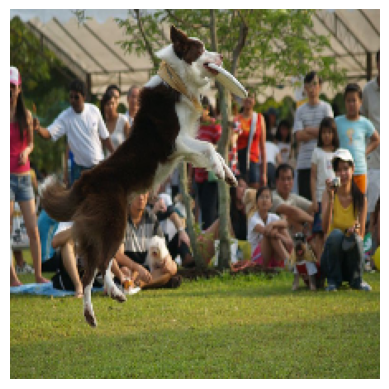

In [68]:
plt.imshow(cv2.resize(plt.imread(join(IMAGE_PATH,img1)),(224,224)))
plt.axis('off')
plt.show()

In [69]:
input,captions,labels = dataset[index]

predicted word: A
(224, 224)


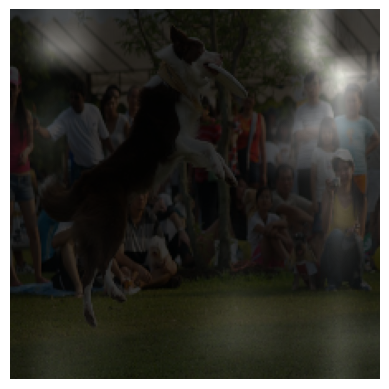

predicted word: black
(224, 224)


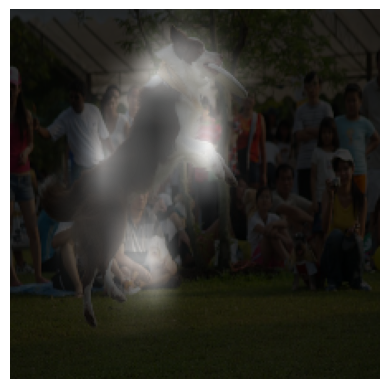

predicted word: and
(224, 224)


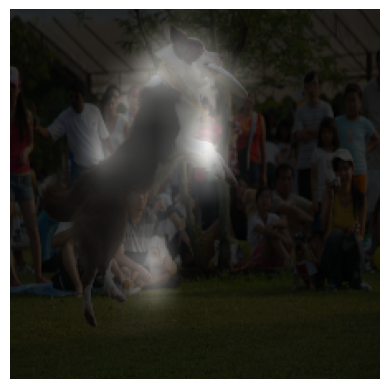

predicted word: white
(224, 224)


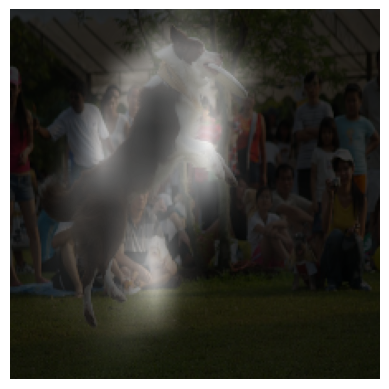

predicted word: dog
(224, 224)


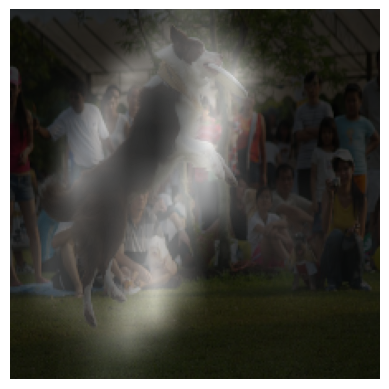

predicted word: jumping
(224, 224)


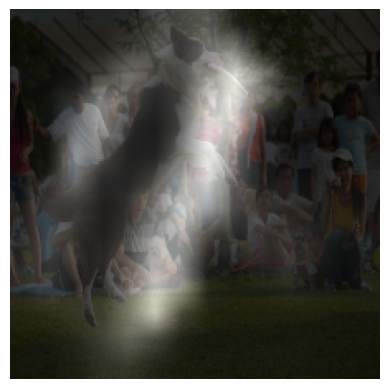

predicted word: a
(224, 224)


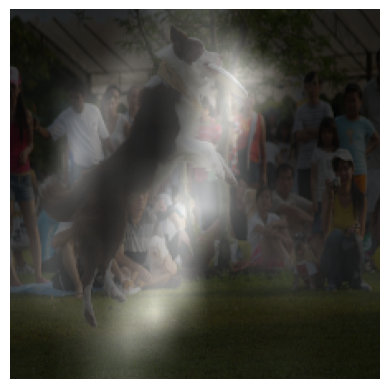

predicted word: a
(224, 224)


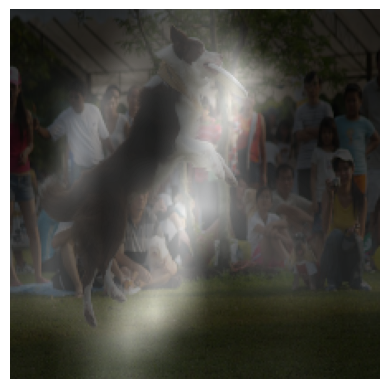

predicted word: Frisbee
(224, 224)


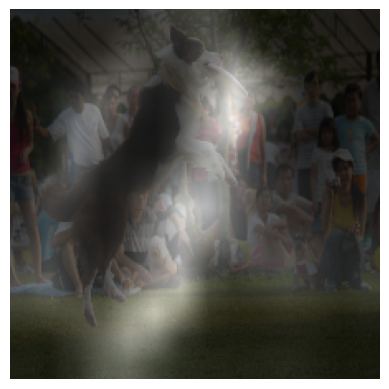

predicted word: in
(224, 224)


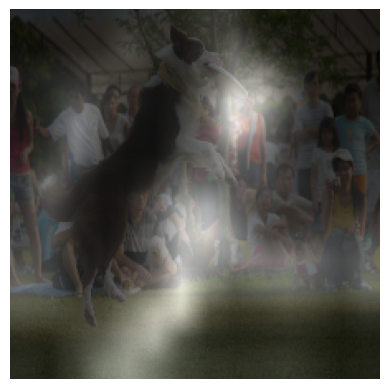

predicted word: a
(224, 224)


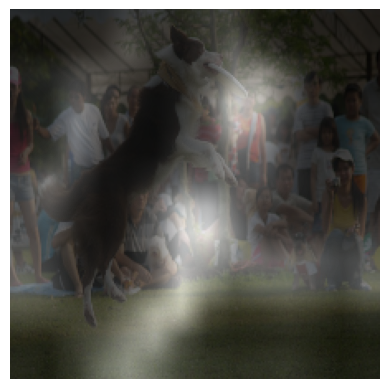

predicted word: of
(224, 224)


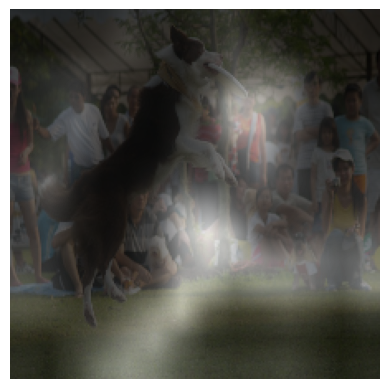

predicted word: a
(224, 224)


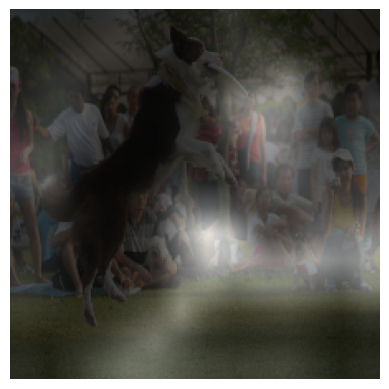

predicted word: audience
(224, 224)


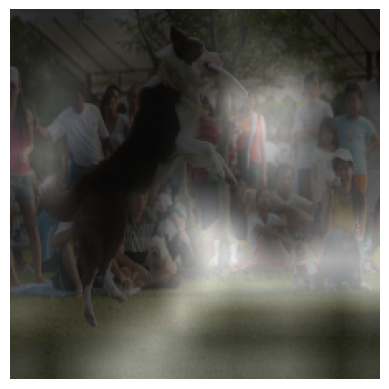

predicted word: .
(224, 224)


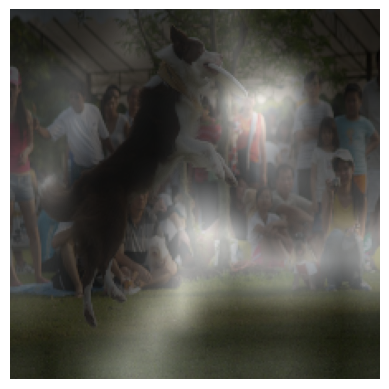

predicted word: <END>
(224, 224)


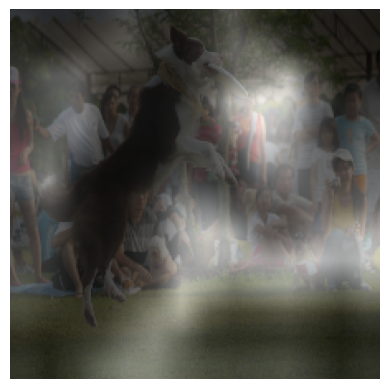

In [70]:
with torch.no_grad():
    a = encoder(input.unsqueeze(0).to(device))
    hn,cn = decoder.init_hidden(a)
    y_prev = torch.zeros((a.shape[0],1),dtype=torch.int64).to(device)
    y_prev[:] = dataset.word2ix['<START>']

    for t in range(500):
        yt = captions[t:(t+1)].unsqueeze(1).to(device)
        y_pred,hn,cn,alpha_i = decoder.forward(a,y_prev,hn,cn)
        print("predicted word:",words[y_pred[0].argmax(1).item()])

        """with torch.no_grad():
            print(words[y_pred[0].argmax(1).item()])
        """
        y_prev = yt
            
        resized_attention = cv2.resize(alpha_i.view(14,14).cpu().detach().numpy()/alpha_i.max().item(),(224,224),fx=16,fy=16)
        blur_attention = cv2.GaussianBlur(resized_attention,(7,7),0)
        print(blur_attention.shape)
        plt.imshow(cv2.resize(plt.imread(join(IMAGE_PATH,img1)),(224,224)))
        plt.imshow(blur_attention,cmap='gray',alpha=.8)
        plt.axis('off')
        plt.show()
        
        if words[y_pred[0].argmax(1).item()] == "<END>":
            break